In [22]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import torch
from torchvision import transforms

sys.path.append('/app/scripts/')

from HAM10000Dataset import HAM10000Dataset
from ModelTester import ModelTester
from SimpleTrainingMetricsPlotter import SimpleTrainingMetricsPlotter
from SkinLesionClassifier import SkinLesionClassifier

# Main directory
base_dir = '/app/'

# Data directory
data_dir = os.path.join(base_dir, "data")

# Directory for images
images_dir = os.path.join(data_dir, "ISIC2018_Task3_Test_Images")

# Path to the metadata CSV file
metadata_file = os.path.join(data_dir, "ISIC2018_Task3_Test_GroundTruth.csv")

# Models directory
models_dir = os.path.join(base_dir, "models")

# Training data directory (for storing training plots and related data)
training_data_dir = os.path.join(base_dir, "training_data/")

# Choose the model architecture
model_name = 'resnet50'

if model_name == 'resnet50':
    model_dir = os.path.join(models_dir, "resnet")
    training_data_output_dir = os.path.join(training_data_dir, "resnet/cross_validation_results_ham10000.csv")
elif model_name == 'densenet121':
    model_dir = os.path.join(models_dir, "densenet")
    training_data_output_dir = os.path.join(training_data_dir, "densenet/cross_validation_results_ham10000.csv")
elif model_name == 'efficientnet_b0':
    model_dir = os.path.join(models_dir, "efficientnet")
    training_data_output_dir = os.path.join(training_data_dir, "efficientnet/cross_validation_results_ham10000.csv")


# Define transformations for test dataset
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the input size of the models
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Initialize the dataset with the image directory
test_dataset = HAM10000Dataset(
    annotations=pd.read_csv(metadata_file),          # Path to the metadata CSV file
    root_dir=images_dir,             # Directory containing images
    transform=val_transform,         # Use the validation transform by default
    augmentations=None,              # Set augmentations to None for testing phase
    balance_classes=False            # No need to balance classes during testing
)


In [23]:
# !apt-get update -y
# !apt-get install libgl1-mesa-glx -y
# !apt-get install libglib2.0-0 -y
# !pip install grad-cam
# !pip install pytorch-gradcam

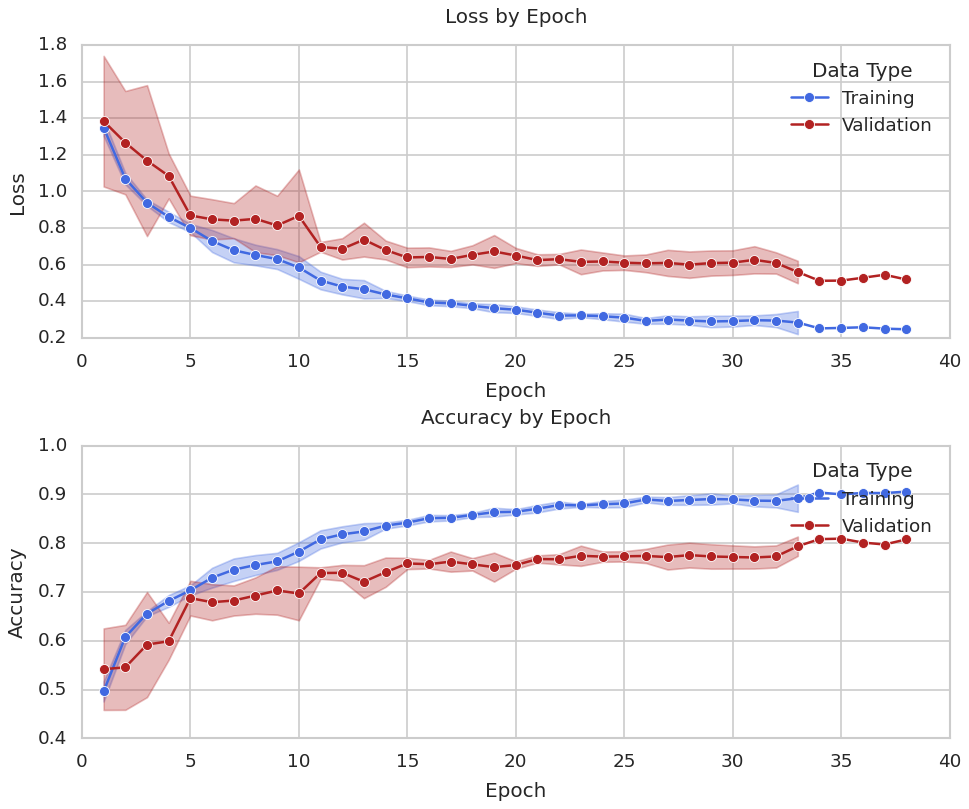

In [24]:
# Initialize the plotter with the DataFrame
plotter = SimpleTrainingMetricsPlotter(pd.read_csv(training_data_output_dir))

# Plot the metrics
plotter.plot_metrics()

In [25]:
def list_files_in_folder(folder_path):
    file_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths

# Example usage
best_model_paths = list_files_in_folder(model_dir)
print(best_model_paths)

['/app/models/resnet/best_model_ham10000_fold_1.pth', '/app/models/resnet/best_model_ham10000_fold_2.pth', '/app/models/resnet/best_model_ham10000_fold_3.pth', '/app/models/resnet/best_model_ham10000_fold_4.pth', '/app/models/resnet/best_model_ham10000_fold_5.pth']


In [26]:
# Initialize the ModelTester
tester = ModelTester(
    model_class=SkinLesionClassifier,  # The class of your model
    test_dataset=test_dataset,         # The test dataset you loaded
    num_classes=7,                     # Number of classes in your dataset (e.g., 7 for HAM10000)
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
)


# Test all folds and get results
reports_per_fold, mean_report = tester.test_all_folds(best_models=best_model_paths)

# Display the reports
for i, report in enumerate(reports_per_fold):
    print(f"Classification Report for Fold {i+1}:\n", pd.DataFrame(report).transpose())

print("\nMean Classification Report across all folds:\n", mean_report)

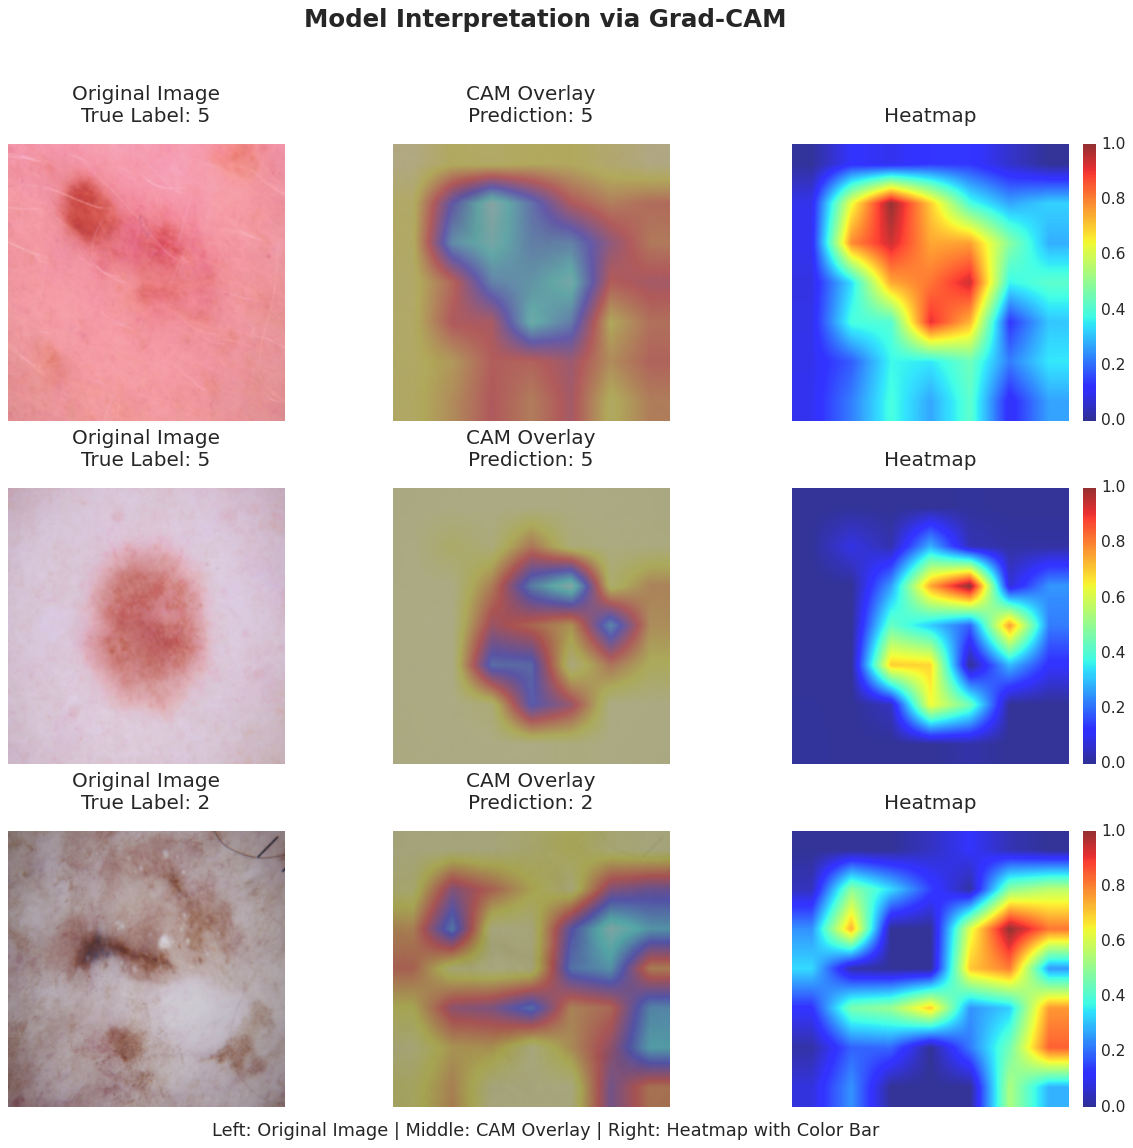

In [27]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the best model
model_path = best_model_paths[0]  # Assuming the first model is the best one
classifier = SkinLesionClassifier(model_name=model_name, num_classes=7, weights=False)
classifier.load_model_weights(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier.model.to(device)

# Set up plotting style for a professional look
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({
    'figure.figsize': (15, 15),  # Adjust figure size based on the number of rows and columns
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'axes.titlepad': 20,
    'axes.labelpad': 10,
    'savefig.dpi': 300,  # High resolution for saving images
    'savefig.bbox': 'tight'  # Ensure the plot is tightly cropped when saved
})

# Set the number of examples you want to display
num_examples = 3  # Adjust based on the number of rows you want
num_columns = 3  # 3 columns for Original Image, CAM Overlay, and Heatmap
num_rows = num_examples

# Create the figure with the specified number of subplots
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Testing the model and generating CAMs
classifier.model.eval()
for i, (input_tensor, label) in enumerate(test_dataset):
    input_tensor = input_tensor.unsqueeze(0).to(device)  # Add batch dimension and send to device

    # Get the prediction
    output = classifier.get_model()(input_tensor)
    _, predicted = torch.max(output, 1)

    # Generate the CAM - ensure gradients are enabled
    input_tensor.requires_grad = True  # Enable gradients for the input tensor
    grayscale_cam = classifier.generate_cam(input_tensor=input_tensor, target_category=predicted.item())

    # Convert the input tensor back to a numpy array
    img_np = input_tensor.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)  # Detach before converting to numpy
    img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
    img_np = np.clip(img_np, 0, 1)

    # Enhance the contrast of the CAM
    grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min())
    
    # Overlay the CAM on the original image
    cam_overlay = classifier.overlay_cam_on_image(img_np, grayscale_cam, alpha=0.6)  # Adjust alpha for better visibility

    # Plot each element in its respective position in the grid
    axs[i, 0].imshow(img_np)
    axs[i, 0].set_title(f"Original Image\nTrue Label: {label}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(cam_overlay)
    axs[i, 1].set_title(f"CAM Overlay\nPrediction: {predicted.item()}")
    axs[i, 1].axis('off')

    heatmap = axs[i, 2].imshow(grayscale_cam, cmap='jet', alpha=0.8)
    axs[i, 2].set_title(f"Heatmap")
    axs[i, 2].axis('off')

    # Add colorbar only to the last column of each row
    plt.colorbar(heatmap, ax=axs[i, 2], fraction=0.046, pad=0.04)

    # Stop after the desired number of examples
    if i >= num_examples - 1:
        break

# Add a common title for the entire figure
fig.suptitle(f"Model Interpretation via Grad-CAM", fontsize=22, weight='bold')

# Add a label below the entire grid explaining each column
fig.text(0.5, 0.04, 'Left: Original Image | Middle: CAM Overlay | Right: Heatmap with Color Bar', ha='center', fontsize=16)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.05, 1, 0.96])

# Save the figure if needed
plt.savefig("grid_comparison_informative.png", dpi=300)

# Show the plot
plt.show()
